In [30]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from datetime import datetime as dt
from datetime import timedelta, date
import matplotlib.image as mpimg
import random
import seaborn as sns

# Load data 


In [31]:
# Load tweet data
tweet_data = pd.read_feather('tweets_sentiment.feather')

#Load poll data
poll_data_in= pd.read_feather('poll_data_by_state.feather')

# Rename column names
poll_data_in.rename(columns={'allocationdate':'date', 'adjpoll_clinton':'cl_d0', \
                          'adjpoll_trump':'tr_d0'},inplace=True)

# Set index of dataframe to state and date
poll_data_in.set_index(['state','date'],inplace=True)

# Add delay columns (features) to poll data

In [32]:
# Initialise data frame
poll_cl=poll_data_in[['cl_d0']]
poll_tr=poll_data_in[['tr_d0']]

# Add column for delayed poll results
max_delay=7          # Max delay considered in this analysis

# Iterate from 1 up to max_delay and add a column from both Clinton and Trump data
for d in range(1,max_delay+1):
    
    # Create a copy of the undelayed date without index
    delay_cl=poll_data_in[['cl_d0']].reset_index()
    delay_tr=poll_data_in[['tr_d0']].reset_index()
    
    # Modify the date by delay parameter d
    delay_cl['date']=pd.to_datetime(delay_cl['date']).apply(pd.DateOffset(-d))
    delay_tr['date']=pd.to_datetime(delay_tr['date']).apply(pd.DateOffset(-d))
    
    # Rename the delayed poll data column
    delay_cl.rename(columns={'cl_d0':'cl_d'+str(d)},inplace=True)
    delay_tr.rename(columns={'tr_d0':'tr_d'+str(d)},inplace=True)
    
    # Set index of dataframe to state and date
    delay_cl.set_index(['state','date'],inplace=True)
    delay_tr.set_index(['state','date'],inplace=True)
    
    # Join the delayed data with the poll data set
    poll_cl=poll_cl.merge(delay_cl,left_index=True,right_index=True)
    poll_tr=poll_tr.merge(delay_tr,left_index=True,right_index=True)
    
#poll_cl.head()
#poll_tr.head()

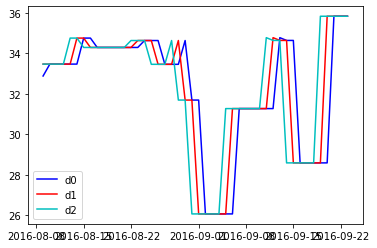

In [33]:
# Visual of columns with delay
plt.plot(poll_cl.loc['AK']['cl_d0'],c='b',label='d0')
plt.plot(poll_cl.loc['AK']['cl_d1'],c='r',label='d1')
plt.plot(poll_cl.loc['AK']['cl_d2'],c='c',label='d2')
plt.legend()

# Aggregate tweet data

In [34]:
# Add column with date as datetime object
tweet_data['date']=pd.to_datetime(tweet_data['created_at'], format='%a %b %d %H:%M:%S +0000 %Y').dt.date

# Aggregate by state and date
tweet_data_grouped=tweet_data.groupby(['state','date'])['sentiment'].value_counts(normalize=True).unstack()

#tweet_data_grouped.head()

# Merge poll and twitter data

In [35]:
cli=tweet_data_grouped.merge(poll_cl,left_index=True,right_index=True)
tru=tweet_data_grouped.merge(poll_tr,left_index=True,right_index=True)

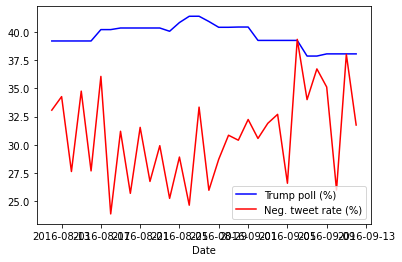

In [36]:
plt.plot(tru.loc['WI'].tr_d0,c='b',label='Trump poll (%)')
plt.plot(tru.loc['WI'].neg*100,c='r',label='Neg. tweet rate (%)')
plt.xlabel("Date")
plt.legend()

# Add delta category columns (features) to poll data

In [37]:
# Deltas for poll data only
cli_poll_columns=[i for i in cli.columns if i[0]=='c']      # Get column names with poll data
tru_poll_columns=[i for i in tru.columns if i[0]=='t']      # Get column names with poll data

# Calculate numeric deltas
cli_poll_delta=cli.groupby(level=0)[cli_poll_columns].diff()
tru_poll_delta=tru.groupby(level=0)[tru_poll_columns].diff()

# Define category thresholds
cli_poll_upper=cli_poll_delta['cl_d0'].std()*0.1
cli_poll_lower=-cli_poll_delta['cl_d0'].std()*0.1

tru_poll_upper=tru_poll_delta['tr_d0'].std()*0.1
tru_poll_lower=-tru_poll_delta['tr_d0'].std()*0.1

# Define category function
def cli_category(input):
    if input > cli_poll_upper:
        return 1 
    elif input >= cli_poll_lower: 
        return 0 
    else: 
        return -1

def tru_category(input):
    if input > tru_poll_upper:
        return 1 
    elif input >= tru_poll_lower: 
        return 0 
    else: 
        return -1
        
# Drop rows with na
cli_poll_delta=cli_poll_delta.dropna(how='any')
tru_poll_delta=tru_poll_delta.dropna(how='any')

# Categorize data
cli_poll_delta=cli_poll_delta.applymap(lambda x: cli_category(x))
tru_poll_delta=tru_poll_delta.applymap(lambda x: tru_category(x))

# Merge categorize
cli_cat=tweet_data_grouped.merge(cli_poll_delta,left_index=True,right_index=True)
tru_cat=tweet_data_grouped.merge(tru_poll_delta,left_index=True,right_index=True)

#tru_cat.head()
#cli_cat.head()

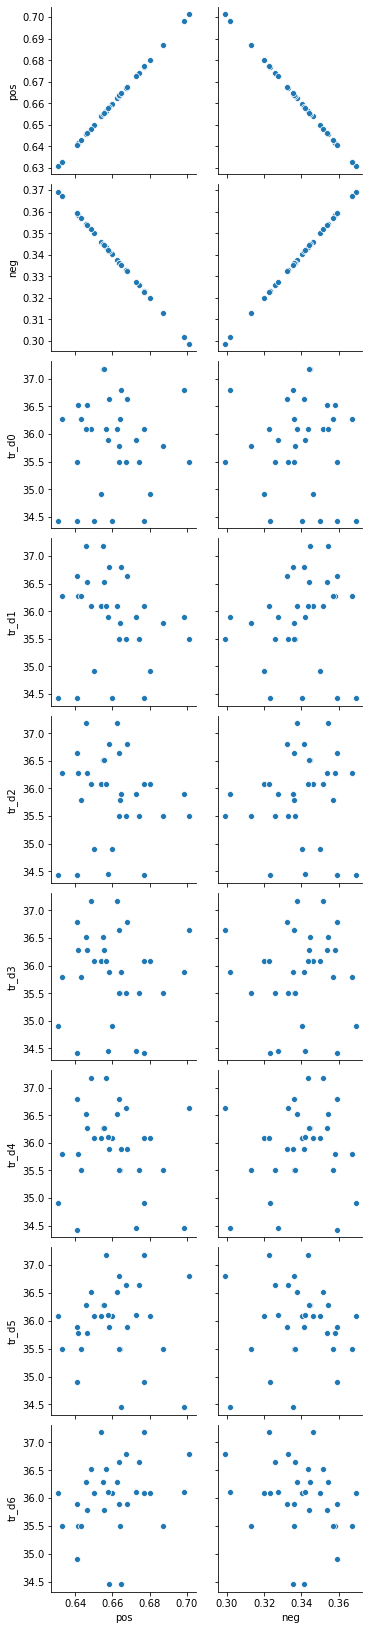

In [38]:
sns.pairplot(tru.loc['NY'],x_vars=['pos','neg'], \
             y_vars=['pos','neg','tr_d0','tr_d1','tr_d2','tr_d3','tr_d4','tr_d5','tr_d6'])

In [39]:
corr_dict=dict()
for k in tru.index.levels[0]:
    corr_dict[k]=tru.loc[k].corr().loc['neg'].to_dict()
    
corr_df=pd.DataFrame.from_dict(corr_dict)        

In [40]:
corr_df=corr_df.drop(labels=['pos','neg'],axis=0)
corr_df.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
tr_d0,-0.022019,0.076366,0.042233,0.176447,-0.054251,0.179778,0.065320,0.119623,-0.170589,0.244301,...,0.175402,-0.125008,-0.039473,-0.099063,-0.096868,-0.387447,0.064345,-0.441939,-0.438945,0.475017
tr_d1,-0.081981,0.141736,0.171816,0.305456,-0.256813,0.161323,0.003345,0.195281,0.001970,0.380063,...,0.119250,-0.032687,-0.090005,-0.224423,-0.053364,0.098997,0.117196,-0.577882,0.101984,0.498253
tr_d2,-0.106518,0.065039,0.090945,-0.124358,-0.279625,0.068964,0.158654,0.263514,0.132791,0.448878,...,0.007418,0.027868,-0.021868,-0.483251,0.127294,0.032764,0.032344,-0.453205,0.256489,-0.097856
tr_d3,-0.056037,0.135302,0.130801,-0.009712,-0.277945,0.110587,0.076920,-0.048423,-0.002305,0.526695,...,-0.112278,0.084268,-0.036430,-0.359652,0.264325,0.248221,0.175509,-0.542348,-0.091033,-0.045381
tr_d4,0.092278,0.356578,0.400158,0.053394,-0.292811,0.279804,0.079851,-0.044999,-0.308694,0.513832,...,0.060264,-0.003109,-0.112256,-0.323489,0.107603,0.111781,0.105151,-0.331011,0.052591,-0.043452


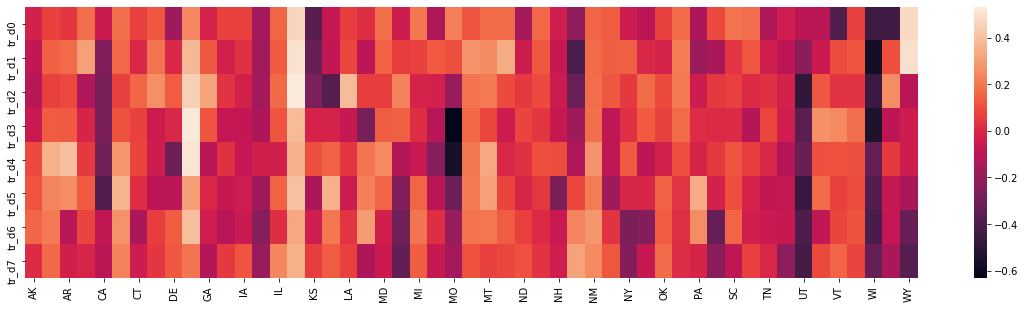

In [42]:
ax=sns.heatmap(corr_df)
ax.figure.set_size_inches(20, 5)

Text(0, 0.5, 'Trump poll (%)')

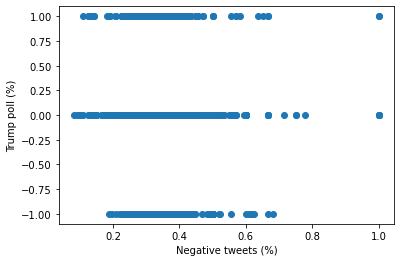

In [41]:
plt.scatter(cli_cat.neg,cli_cat.cl_d0)
plt.xlabel("Negative tweets (%)")
plt.ylabel("Trump poll (%)")

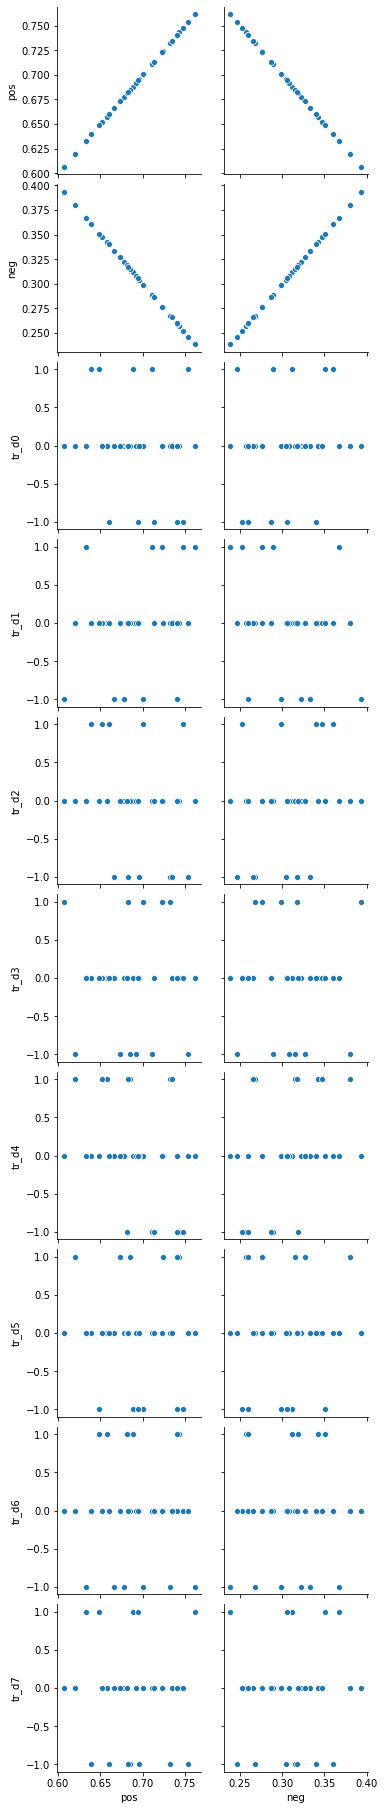

In [45]:
ax1=sns.pairplot(tru_cat.loc['WI'],x_vars=['pos','neg'], \
             y_vars=['pos','neg','tr_d0','tr_d1','tr_d2','tr_d3','tr_d4','tr_d5','tr_d6','tr_d7'])